In [1]:
get_ipython().magic('matplotlib inline')

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.svm import SVC
import pylab as pl
import xgboost as xgb

from functools import reduce

In [2]:
def itercols(dataframe):
    for col in dataframe.columns:
        yield (col, dataframe[col])

In [3]:
RAND_SEED = 65535
KCV = 5

In [4]:
from pandas import read_csv, DataFrame, Series
data = read_csv('~/kaggle/santander/train.csv')

In [5]:
cdata = data.drop(['ID', 'TARGET'], axis = 1)
cdata[[kv[0] for kv in filter(lambda kv: kv[1], cdata.mean().isnull().items())]].count()

Series([], dtype: int64)

In [6]:
#removing constant features
constant_features = []
for col in cdata.columns:
    if (np.abs(cdata[col].std()) < 1e-10):
        constant_features += [col]
        
print("Constant features: ", constant_features)
cdata = cdata.drop(constant_features, axis = 1)

Constant features:  ['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var27_0', 'num_var28_0', 'num_var28', 'num_var27', 'num_var41', 'num_var46_0', 'num_var46', 'saldo_var28', 'saldo_var27', 'saldo_var41', 'saldo_var46', 'imp_amort_var18_hace3', 'imp_amort_var34_hace3', 'imp_reemb_var13_hace3', 'imp_reemb_var33_hace3', 'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3', 'num_var2_0_ult1', 'num_var2_ult1', 'num_reemb_var13_hace3', 'num_reemb_var33_hace3', 'num_trasp_var17_out_hace3', 'num_trasp_var33_out_hace3', 'saldo_var2_ult1', 'saldo_medio_var13_medio_hace3']


In [7]:
#log scaling features with higher than criterion_to_log difference between min and max
criterion_to_log = 1e2
cols_to_log = [kv[0] for kv in filter(lambda nc: np.abs(nc[1].min() - nc[1].max()) > criterion_to_log, itercols(cdata))]
offsets = {}
for col in cols_to_log:
    offset = np.abs(cdata[col]).max() + np.exp(1)
    offsets[col] = offset
    cdata[col] = np.log(cdata[col] + offset)

In [8]:
means = {}
deviations = {}

for col in cdata.columns:
    ser = cdata[col]
    
    mean = ser.mean()
    if np.abs(mean) < 1e-10:
        continue
    
    dev = ser.std()
    if np.abs(dev) < 1e-10:
        continue
    
    means[col] = mean
    deviations[col] = dev
    
    cdata[col] = (ser - mean) / dev

In [9]:
#removing identical features
identical_feature_groups = {}
idx_to_skip = []
for idx1, col1 in enumerate(cdata.columns):
    if idx1 in idx_to_skip:
        continue
    identical_feature_groups[col1] = []
    for idx2, col2 in enumerate(cdata.columns[idx1 + 1:]):
        if all(map(lambda x: x < 1e-10, np.abs(cdata[col1] - cdata[col2]))):
            identical_feature_groups[col1] += [col2]
            idx_to_skip += [idx2]

In [ ]:
id_grp = dict(filter(lambda kv: len(kv[1]) > 0, identical_feature_groups.items()))
print("Identical groups:")
for k, v in id_grp.items():
    print("{0:30} | {1}".format(k, ', '.join(v)))

In [10]:
identical_features = list(reduce(lambda x, y: x + y, identical_feature_groups.values()))
cdata = cdata.drop(identical_features, axis = 1)

print("Removed identical features: ", identical_features)

Removed identical features:  ['delta_num_trasp_var17_in_1y3', 'delta_num_reemb_var13_1y3', 'saldo_var29', 'ind_var26', 'num_var40', 'num_var39', 'delta_num_trasp_var33_in_1y3', 'saldo_medio_var13_medio_ult1', 'ind_var29_0', 'num_var6_0', 'num_var29_0', 'num_var34', 'ind_var25', 'num_var37', 'ind_var13_medio', 'num_var13_medio_0', 'num_var13_medio', 'num_meses_var13_medio_ult3', 'delta_num_reemb_var17_1y3', 'ind_var32', 'delta_num_trasp_var17_out_1y3', 'num_var26', 'num_meses_var13_medio_ult3', 'ind_var34', 'num_var34_0', 'num_var34', 'num_var44', 'num_var29_0', 'ind_var29', 'num_var32', 'ind_var18', 'num_var18_0', 'num_var18', 'num_var13_medio_0', 'num_var13_medio', 'num_meses_var13_medio_ult3', 'ind_var39', 'num_var40', 'num_var39', 'delta_num_reemb_var33_1y3', 'delta_num_trasp_var33_out_1y3', 'num_var20_0', 'num_var18', 'num_var29', 'num_var8', 'num_var18_0', 'num_var18', 'ind_var37', 'num_var20', 'num_var13_medio', 'num_meses_var13_medio_ult3', 'num_var6_0', 'num_var29_0', 'num_var3

In [11]:
testdata = read_csv('~/kaggle/santander/test.csv')
ctestdata = testdata.drop(['ID'], axis=1)

In [12]:
#removing constant and identical features by constant_features and identical_features respectively
ctestdata = ctestdata.drop(constant_features + identical_features, axis = 1)

In [13]:
#log scaling test samle
for col in cols_to_log:
    if col in ctestdata.columns:
        offset = offsets[col]
        ctestdata[col] = np.log(ctestdata[col] + offset)

In [14]:
#standardizing
for col in means:
    if col in ctestdata.columns:
        mean, dev = means[col], deviations[col]
        ctestdata[col] = (ctestdata[col] - mean) / dev

In [15]:
Y = data['TARGET']
X = cdata

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = RAND_SEED)

In [ ]:
#feature selection
#N_FEATURES_TO_SELECT = cdata.shape[1] // 2
#fc = SelectKBest(f_classif, k = N_FEATURES_TO_SELECT)
#X_train = DataFrame(fc.fit_transform(X_train, y_train))
#X_test = DataFrame(fc.transform(X_test))

In [17]:
model_xgb = xgb.XGBClassifier(\
    nthread = -1,\
    n_estimators = 560,\
    max_depth = 5,\
    learning_rate = 0.0202048,\
    min_child_weight = 9,\
    subsample = 0.68155,\
    gamma = 0.66,\
    colsample_bytree = 0.7012,\
    seed = RAND_SEED,\
)

model_rfc = RandomForestClassifier(n_estimators = 1000, n_jobs = -1, random_state = RAND_SEED)
model_etc = ExtraTreesClassifier(n_estimators = 1000, n_jobs = -1, bootstrap = True, class_weight = 'balanced', random_state = RAND_SEED)

In [21]:
cvd = {}
scores = cross_validation.cross_val_score(model_rfc, X_train, y_train, cv = KCV, n_jobs = -1)
cvd['RandomForestClassifier'] = scores

In [24]:
scores = cross_validation.cross_val_score(model_etc, X_train, y_train, cv = KCV, n_jobs = -1)
cvd['ExtraTreesClassifier'] = scores

In [22]:
scores = cross_validation.cross_val_score(model_xgb, X_train, y_train, cv = KCV, n_jobs = -1)
cvd['XGBClassifier'] = scores

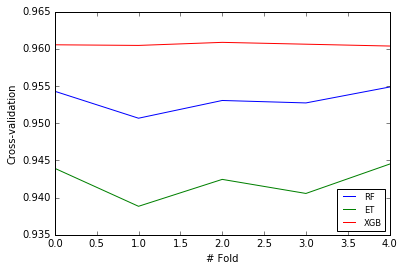

Scores =  [ 0.94393292  0.93883088  0.94244841  0.94055743  0.94450382]


In [25]:
pl.clf()
pl.plot(range(len(scores)), cvd['RandomForestClassifier'], label = "RF")
pl.plot(range(len(scores)), cvd['ExtraTreesClassifier'], label = "ET")
pl.plot(range(len(scores)), cvd['XGBClassifier'], label = "XGB")
pl.xlabel('# Fold')
pl.ylabel('Cross-validation')
pl.legend(loc = 0, fontsize = 'small')
pl.show()

print("Scores = ", scores)

In [26]:
#stacking preparation
cdata['TARGET'] = data['TARGET']
cdata_shuffled = cdata.iloc(np.random.permutation(len(X_train)))[:].copy(deep = True).reset_index(drop = True)
validate_sz = int(0.2 * len(cdata))
Xy_validate = cdata_shuffled[-validate_sz:]
Xy_train = cdata_shuffled[:-validate_sz]

X_validate, y_validate = Xy_validate.drop(['TARGET'], axis = 1), Xy_validate['TARGET']
X_train, y_train = Xy_train.drop(['TARGET'], axis = 1), Xy_train['TARGET']

In [32]:
#stacking layer 0
cls0 = {'RF' : model_rfc, 'XGB' : model_xgb} #'ET' : model_etc
DS0 = []

size = len(Xy_train) // len(cls0)
for i in range(len(cls0) - 1):
    DS0 += [Xy_train.ix[i*size : (i+1)*size - 1, :]]
DS0 += [Xy_train.ix[(len(cls0) - 1)*size :, :]]

L0_train_data_d = {}
L0_test_data_d = {}
L0_fitted_cls_d = {}
for i, (cl_name, cl) in enumerate(cls0.items()):
    fitted_cl = cl.fit(DS0[i].drop('TARGET', axis = 1), DS0[i]['TARGET'])
    L0_fitted_cls_d[cl_name] = fitted_cl
    L0_train_data_d[cl_name] = fitted_cl.predict_proba(X_train)[:, 1]
    L0_test_data_d[cl_name] = fitted_cl.predict_proba(X_validate)[:, 1]
    
L0_train_data = DataFrame.from_dict(L0_train_data_d)
L0_train_data['TARGET'] = y_train

L0_test_data = DataFrame.from_dict(L0_test_data_d)
L0_test_data['TARGET'] = y_validate

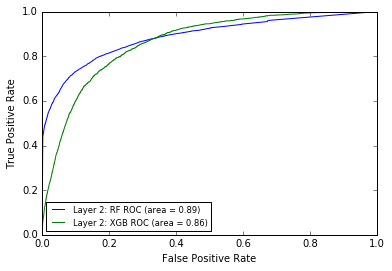

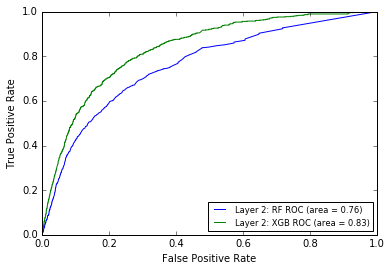

In [33]:
#layer 0 roc auc
pl.clf()

for name, P in L0_train_data_d.items():
    fpr, tpr, thresholds = roc_curve(y_train, P)
    roc_auc = auc(fpr, tpr)
    pl.plot(fpr, tpr, label = '%s ROC (area = %0.2f)' % ('Layer 2: {0}'.format(name), roc_auc))
    
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show()

#

pl.clf()

for name, P in L0_test_data_d.items():
    fpr, tpr, thresholds = roc_curve(y_validate, P)
    roc_auc = auc(fpr, tpr)
    pl.plot(fpr, tpr, label = '%s ROC (area = %0.2f)' % ('Layer 2: {0}'.format(name), roc_auc))

pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show()

In [34]:
#stacking layer 1
model_l1 = xgb.XGBClassifier(\
    nthread = -1,\
    n_estimators = 1000,\
    max_depth = 2,\
    learning_rate = 0.02,\
    subsample = 0.68155,\
    gamma = 0.66,\
    colsample_bytree = 0.7012,\
    seed = RAND_SEED,\
)
fitted_l1 = model_l1.fit(L0_train_data.drop('TARGET', axis = 1), L0_train_data['TARGET'])
l1_probas = fitted_l1.predict_proba(L0_test_data.drop('TARGET', axis = 1))

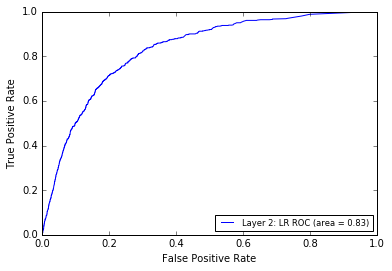

In [35]:
#layer 1 roc auc
pl.clf()

fpr, tpr, thresholds = roc_curve(y_validate, l1_probas[:, 1])
roc_auc = auc(fpr, tpr)
pl.plot(fpr, tpr, label = '%s ROC (area = %0.2f)' % ('Layer 2: LR', roc_auc))

pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show()

In [31]:
#predicting submission
result = DataFrame(testdata['ID'])

L0_preds_d = {}
for name, cl in cls0.items():
    L0_preds_d[name] = L0_fitted_cls_d[name].predict_proba(ctestdata)[:, 1]
L0_data_d = DataFrame.from_dict(L0_preds_d)
res_probas = model_l1.predict_proba(L0_data_d)[:, 1]
    
result.insert(1,'TARGET', res_probas)
result.to_csv('~/ml/kaggle_santander_happy_customers/res_xgb.csv', index = False)